In [1]:
import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as fft
import sigpy
import skimage
import os
import multiprocessing as mp
from multiprocessing import Pool
from PIL import Image
from tqdm import tqdm
import glob

from data_conversion import process_h5_singlecoil, process_h5_multicoil

/home/trevor/miniconda3/envs/edm/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data conversion:
h5 format to a float32 numpy array with 2 channels (real,complex)

In [2]:
datasetpath = os.path.expanduser("~") + '/../../' + 'mdata1/multicoil_train/*.h5'
filelist = sorted(glob.glob(datasetpath))
len(filelist)

4469

# High dynamic range conversion
kspace conversion from native to high contrast format using y=1/x

In [ ]:
outshape=(200,200)
sampling_ratio=(2,1)
savedir='data'

with h5py.File(filelist[-1],'r') as f:
    kspace = np.array(f['kspace'])
# recon = np.array(f['reconstruction_rss'])
    kspace_cropped = kspace[:,:,0::sampling_ratio[0],:]+kspace[:,:,1::sampling_ratio[0],:]
    slices, coils, height, width = kspace_cropped.shape    #kspace opens as (z, coils, height, width)
    kspace_cropped = kspace_cropped[:,:,int((height/2)-(outshape[0]/2)):int((height/2)+(outshape[0]/2)), 
                                int((width/2)-(outshape[1]/2)):int((width/2)+(outshape[1]/2))].copy()

    # kspace_cropped = kspace[:,:,int((height/2)-(outshape[0]*sampling_ratio[0]/2)):int((height/2)+(outshape[0]*sampling_ratio[0]/2)):sampling_ratio[0], 
    #                             int((width/2)-(outshape[1]*sampling_ratio[1]/2)):int((width/2)+(outshape[1]*sampling_ratio[1]/2)):sampling_ratio[1]].copy()
    

    for zslice in range(kspace_cropped.shape[0]):
        for coil in range(kspace_cropped.shape[1]):
            array = np.stack((kspace_cropped[zslice,coil,:,:].real,
                              kspace_cropped[zslice,coil,:,:].imag,),
                              axis=-1)
            
            print(array.shape)
            
            break
        break


In [ ]:
import matplotlib.pyplot as plt
a = np.histogram(array.real.flatten(),500)
plt.plot(a[1][:-1],a[0])

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 6))

ax[0].imshow(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j)))
ax[1].imshow(np.abs(array[:,:,0]+array[:,:,1]*1j))

In [ ]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 6))

ax[0].imshow(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j)))
ax[1].imshow(np.abs(array[:,:,0]+array[:,:,1]*1j))

In [ ]:
arr_adjusted = np.divide(np.ones_like(array),array)

arr_adjusted = np.clip(arr_adjusted,-1000000,1000000)

arr_adjusted[np.isinf(arr_adjusted)]=1000000

# arr_adjusted = ((arr_adjusted+1000000)/2000000.0*255).astype(np.uint8)


a = np.histogram(arr_adjusted.flatten(),500)
plt.plot(a[1][:-1],a[0])

In [ ]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 6))

ax[0].imshow(np.abs(sigpy.fft(arr_adjusted[:,:,0]+arr_adjusted[:,:,1]*1j)))
ax[1].imshow(np.abs(arr_adjusted[:,:,0]+arr_adjusted[:,:,1]*1j))

In [ ]:
# arr_restored = ((arr_adjusted.astype(np.float32)/255-0.5)*2000000.0)

arr_restored = np.divide(np.ones_like(arr_adjusted),arr_adjusted)

a = np.histogram(arr_restored.flatten(),500)
plt.plot(a[1][:-1],a[0])

In [ ]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 6))

ax[0].imshow(np.abs(sigpy.fft(arr_restored[:,:,0]+arr_restored[:,:,1]*1j)))
ax[1].imshow(np.abs(arr_restored[:,:,0]+arr_restored[:,:,1]*1j))

# Non cartesian trajectory testing and plotting

In [ ]:
import sigpy.mri
from scipy.spatial import Voronoi, ConvexHull
from fastkde.fastKDE import pdf,pdf_at_points
import numpy as np


def generate_trajectory(matsize, interleave_range = (1,8), undersampling = 1, alpha_range = (1,4)):
    interleaves = int(np.random.rand()*(interleave_range[1]-interleave_range[0])+interleave_range[0])
    alpha = np.random.rand()*(alpha_range[1]-alpha_range[0])+alpha_range[0]

    return make_trajectory(matsize, undersampling = undersampling, interleaves = interleaves, alpha = alpha),alpha

def make_trajectory(matsize, undersampling=1, interleaves=1, alpha=1):

    fov = .25 #in meters
    adjustedshape = np.power(matsize[0]**2+matsize[1]**2,0.5)
    frequency_encode_undersampling = 1
    max_gradient_amp = 0.045 #T/m  4.5 G/cm, or 2.2 G/cm
    max_slew_rate = 0.1 #T/m/ms

    u = .0365 / undersampling * (1-2*(((1/alpha)**4)-(1/alpha)**2)) # Empirically determined as a decent approximation for maintaining a steady effective undersampling rate
    
    interleaves = interleaves

    points = sigpy.mri.spiral(fov, 
                            adjustedshape, 
                            frequency_encode_undersampling, 
                            u, 
                            interleaves, 
                            alpha, 
                            max_gradient_amp, 
                            max_slew_rate)

    points = np.asarray([i for i in points if -matsize[0]/2<=i[0]<=matsize[0]/2 and -matsize[1]/2<=i[1]<=matsize[1]/2]) #trim excess
    information_ratio = points.shape[0] / (matsize[0]*matsize[1]) #recalculate the new information sampling

    print('information_ratio: {}'.format(information_ratio))

    return points

def interpolate_values(points,kimage):
    assert kimage.dtype == 'complex64'
    # return sigpy.interpolate(kimage, points, kernel='spline', width=2, param=1)
    mag_image = np.abs(sigpy.ifft(kimage))
    return sigpy.nufft(mag_image, points)

def voronoi_volumes(points):
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    for i, reg_num in enumerate(v.point_region):
        indices = v.regions[reg_num]
        if -1 in indices: # some regions can be opened
            vol[i] = np.inf
        else:
            vol[i] = ConvexHull(v.vertices[indices]).volume
    return vol

def get_pdf_at_points(points):
    test_points = list(points)
    return pdf_at_points(points[:,0], points[:,1], list_of_points = test_points)

def voronoi_density_correction(points,values): #moderately slow, no improvement
    volumes = voronoi_volumes(points)
    volumes[np.isinf(volumes)] = 1
    return values*(volumes**0.5)

def simple_density_correction(points,values):   #simple correction by a factor of r universal, seems to work the best...
    values_c = values.copy()
    return values_c * np.power(np.power(points[:,0],2) + np.power(points[:,1],2), 0.5)

def fast_density_correction(points,values,alpha,scalefactor=0.5):   #variable correction by a factor of r^alpha universal, mixed results...
    values_c = values.copy()
    # return values_c * np.power(np.power(np.power(points[:,0],2) + np.power(points[:,1],2),0.5),(1/alpha**0.5))
    # return values_c * np.power(np.power(np.power(points[:,0],2) + np.power(points[:,1],2),0.5),(1/alpha**scalefactor))
    return values_c * np.power(np.power(points[:,0],2) + np.power(points[:,1],2), (1-5**(1-alpha))/2 )



def kde_density_correction(points,values):   #extremely slow, no improvement
    values_c = values.copy()
    densities = get_pdf_at_points(points)
    return np.divide(values_c,np.abs(densities))

def NUFFT_adjoint(points,values,alpha):
    values_c = fast_density_correction(points,values,alpha)
    image_2ch = sigpy.nufft_adjoint(values_c, points, oshape=(200, 200), oversamp=1)
    image_2ch = np.flip(np.flip(image_2ch,axis=0),axis=1)
    return image_2ch

In [ ]:
kspace_complex = array[:,:,0]+array[:,:,1]*1j

points,alpha = generate_trajectory(kspace_complex.shape, interleave_range = (5,5), undersampling = 0.125, alpha_range = (1.1,1.1)) # FIXED TRAJECTORY AT 0.25 INFORMATION RATIO
print('alpha: ',alpha)

values = interpolate_values(points,kspace_complex)
image = NUFFT_adjoint(points,values,alpha)

In [ ]:
# image = sigpy.ifft(array[:,:,0]+array[:,:,1]*1j)

# image = np.stack((image.real,image.imag),axis=-1)

# print(np.amax(image[:,:,0])*10000)
# print(np.amin(image[:,:,0])*10000)
# print(np.amax(image[:,:,1])*10000)
# print(np.amin(image[:,:,1])*10000)

# print(np.amax(np.abs(image))*10000)
# print(np.amin(np.abs(image))*10000)

In [ ]:
import seaborn as sns
sns.set_palette('CMRmap')

sns.jointplot(x=points[:,0],y=points[:,1],marginal_kws=dict(bins=50),height=3, marker=".")
sns.jointplot(points,height=3,marker=".")

In [ ]:
imshape = (200,200)

values_c = values
im1 = sigpy.nufft_adjoint(values_c, points, oshape=imshape, oversamp=1)
im1 = np.flip(np.flip(im1,axis=0),axis=1)

values_c = simple_density_correction(points,values)
im2 = sigpy.nufft_adjoint(values_c, points, oshape=imshape, oversamp=1)
im2 = np.flip(np.flip(im2,axis=0),axis=1)

values_c = fast_density_correction(points,values,alpha)
im3 = sigpy.nufft_adjoint(values_c, points, oshape=imshape, oversamp=1)
im3 = np.flip(np.flip(im3,axis=0),axis=1)

In [ ]:
fig, ax = plt.subplots(2, 4, constrained_layout=True, figsize=(48, 24))
ax[0,0].imshow(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j))) #Ground truth image array
ax[0,1].imshow(np.abs(im1))  #no density correction
ax[0,2].imshow(np.abs(im2))  #simple harmonic density correction
ax[0,3].imshow(np.abs(im3))  #voronoi density correction

ax[1,0].imshow(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j))/np.mean(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j)))-np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j))/np.mean(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j))),vmin=-5, vmax=5) #Ground truth image array
ax[1,1].imshow(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j))/np.mean(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j)))-np.abs(im1)/np.mean(np.abs(im1)),vmin=-5, vmax=5)  #no density correction
ax[1,2].imshow(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j))/np.mean(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j)))-np.abs(im2)/np.mean(np.abs(im2)),vmin=-5, vmax=5)  #simple harmonic density correction
ax[1,3].imshow(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j))/np.mean(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j)))-np.abs(im3)/np.mean(np.abs(im3)),vmin=-5, vmax=5)  #voronoi density correction

In [ ]:
print(np.mean(np.abs(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j))/np.mean(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j)))-np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j))/np.mean(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j)))))) #Ground truth image array
print(np.mean(np.abs(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j))/np.mean(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j)))-np.abs(im1)/np.mean(np.abs(im1)))))  #no density correction
print(np.mean(np.abs(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j))/np.mean(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j)))-np.abs(im2)/np.mean(np.abs(im2)))))  #simple harmonic density correction
print(np.mean(np.abs(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j))/np.mean(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j)))-np.abs(im3)/np.mean(np.abs(im3)))))  #voronoi density correction

In [ ]:
fig, ax = plt.subplots(2, 4, constrained_layout=True, figsize=(48, 24))
ax[0,0].imshow(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j))) #Ground truth image array
ax[0,1].imshow(np.abs(im1))  #no density correction
ax[0,2].imshow(np.abs(im2))  #simple harmonic density correction
ax[0,3].imshow(np.abs(im3))  #voronoi density correction


ax[1,0].imshow(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j))/np.mean(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j)))-np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j))/np.mean(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j))),vmin=-5, vmax=5) #Ground truth image array
ax[1,1].imshow(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j))/np.mean(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j)))-np.abs(im1)/np.mean(np.abs(im1)),vmin=-5, vmax=5)  #no density correction
ax[1,2].imshow(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j))/np.mean(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j)))-np.abs(im2)/np.mean(np.abs(im2)),vmin=-5, vmax=5)  #simple harmonic density correction
ax[1,3].imshow(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j))/np.mean(np.abs(sigpy.fft(array[:,:,0]+array[:,:,1]*1j)))-np.abs(im3)/np.mean(np.abs(im3)),vmin=-5, vmax=5)  #voronoi density correction

# Trajectory Interpolation and NUFFT testing

In [ ]:
from noncart_training.trajectory import *

In [ ]:
raw = kspace_cropped

In [ ]:
points, alpha = generate_trajectory(raw[0,0].shape, interleave_range = (1,8), undersampling = 0.5, alpha_range = (1,4))
print(len(points))
print(alpha)

In [ ]:
plot_trajectory(points)

In [ ]:
mapped_values = map_values(points,raw[0,0,:,:])
interped_values = interpolate_values(points,raw[0,0,:,:])

In [ ]:
interp_image = NUFFT_adjoint(points,interped_values,raw[0,0,:,:].shape,alpha)
map_image = NUFFT_adjoint(points,mapped_values,raw[0,0,:,:].shape,alpha)

In [ ]:
plt.imshow(np.abs(map_image))
plt.show()
plt.imshow(np.abs(interp_image))
plt.show()

# Dataset testing

In [3]:
# Dataset testing

from noncart_training.dataset import *
from dnnlib.util import *
from torch_utils import distributed as dist
from torch_utils import misc
from noncart_training.trajectory import *

In [41]:
# Load dataset.
seeds = [0,]
dataset_kwargs = dnnlib.EasyDict(class_name='noncart_training.dataset.NonCartesianDataset', path='data_64_multicoil', use_labels=False, xflip=False, fetch_raw=True, undersampling=0.2)
data_loader_kwargs = dnnlib.EasyDict(pin_memory=True, num_workers=8, prefetch_factor=2)
dist.print0('Loading dataset...')
dataset_obj = dnnlib.util.construct_class_by_name(**dataset_kwargs) # subclass of training.dataset.Dataset
dataset_sampler = misc.InfiniteSampler(dataset=dataset_obj, rank=dist.get_rank(), num_replicas=dist.get_world_size(), seed=seeds[0])
dataset_iterator = iter(torch.utils.data.DataLoader(dataset=dataset_obj, sampler=dataset_sampler, batch_size=1, **data_loader_kwargs))

Loading dataset...


In [42]:
parcel = next(dataset_iterator)

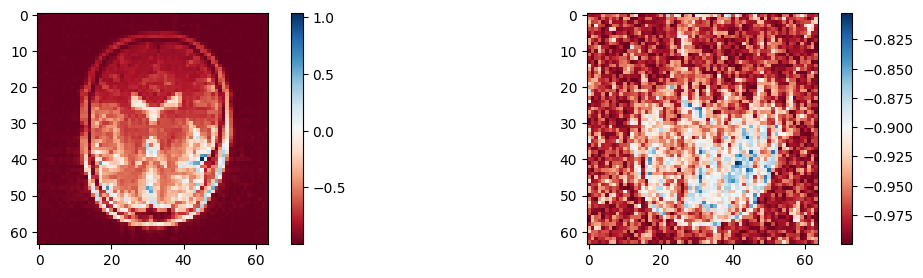

In [43]:
fig, (ax1,ax2) = plt.subplots(figsize=(13, 3), ncols=2)

pos1 = ax1.imshow(parcel[0][0,4,:,:], cmap='RdBu', interpolation='none')
fig.colorbar(pos1, ax=ax1)

pos2 = ax2.imshow(parcel[1][0,4,:,:], cmap='RdBu', interpolation='none')
fig.colorbar(pos2, ax=ax2)

plt.show()

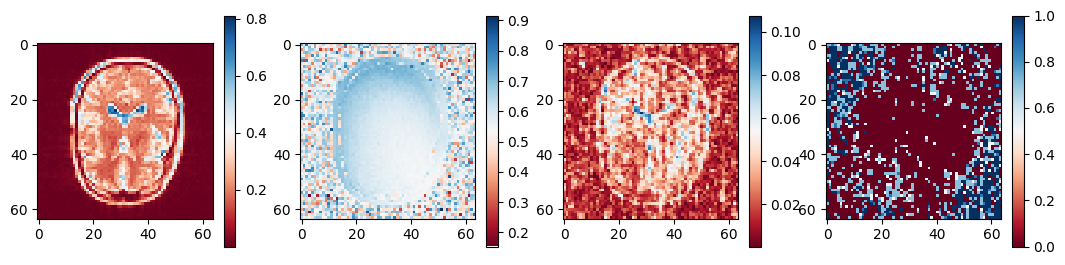

In [44]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(figsize=(13, 3), ncols=4)

pos1 = ax1.imshow(root_summed_squares(parcel[0])[0][0], cmap='RdBu', interpolation='none')
fig.colorbar(pos1, ax=ax1)

pos2 = ax2.imshow(root_summed_squares(parcel[0])[1][0], cmap='RdBu', interpolation='none')
fig.colorbar(pos2, ax=ax2)

pos3 = ax3.imshow(root_summed_squares(parcel[1])[0][0], cmap='RdBu', interpolation='none')
fig.colorbar(pos3, ax=ax3)

pos4 = ax4.imshow(root_summed_squares(parcel[1])[1][0], cmap='RdBu', interpolation='none')
fig.colorbar(pos4, ax=ax4)

plt.show()

In [35]:
gt_image_mag, gt_image_pha = root_summed_squares(parcel[0])
gt_image_mag = (gt_image_mag[0].numpy()*255).clip(0, 255).astype(np.uint8)
gt_image_pha = (gt_image_pha[0].numpy()*255).clip(0, 255).astype(np.uint8)


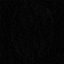

In [36]:
images, priors, labels, kspace = dataset_obj[14154]
images = torch.Tensor(images).to(torch.float32)
priors = torch.Tensor(priors).to(torch.float32)
images = torch.unsqueeze(images,0)
priors = torch.unsqueeze(priors,0)
assert len(images.shape)==4, 'batch dimension is not here during validation check' #check to make sure batch dimension is present

gt_image_mag, gt_image_pha = root_summed_squares(images)

gt_image_mag = (gt_image_mag.numpy()*255).clip(0, 255).astype(np.uint8)
gt_image_pha = (gt_image_pha.numpy()*255).clip(0, 255).astype(np.uint8)

prior_image_mag, prior_image_pha = root_summed_squares(priors)

prior_image_mag = (prior_image_mag.cpu().numpy()*255).clip(0, 255).astype(np.uint8)
prior_image_pha = (prior_image_pha.cpu().numpy()*255).clip(0, 255).astype(np.uint8)

PIL.Image.fromarray(prior_image_mag[0],'L')

In [17]:
images, priors, labels, kspace = next(dataset_iterator)
images = torch.Tensor(images).to(torch.float32)
priors = torch.Tensor(priors).to(torch.float32)
# images = torch.unsqueeze(images,0)
# priors = torch.unsqueeze(priors,0)
assert len(images.shape)==4, 'batch dimension is not here during validation check' #check to make sure batch dimension is present

print(torch.amax(images))
print(torch.amin(images))

gt_image_mag, gt_image_pha = root_summed_squares(images)

gt_image_mag = (gt_image_mag.numpy()*255).clip(0, 255).astype(np.uint8)
gt_image_pha = (gt_image_pha.numpy()*255).clip(0, 255).astype(np.uint8)

print(np.amax(gt_image_mag))
print(np.amin(gt_image_mag))

tensor(1.0709)
tensor(-1.)
168
0
